In [1]:
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), '../core'))
import kaggle_support as kgs
import importlib
import matplotlib.pyplot as plt
importlib.reload(kgs)
import numpy as np
import cupy as cp
from dataclasses import dataclass, field, fields
import pack_cuda
import pack_vis
import pack_cost
import copy
from IPython.display import HTML, display, clear_output
kgs.set_float32(True)
pack_cuda._ensure_initialized()


local
local
init CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling kernel variant: crystal ===
Defines: ENABLE_CRYSTAL_AXES, ENABLE_OVERLAP_AREA, ENABLE_SEPARATION
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -DENABLE_CRYSTAL_AXES -DENABLE_OVERLAP_AREA -DENABLE_SEPARATION -cubin /mnt/d//packing/temp/pack_cuda_saved.cu -o /mnt/d//packing/temp/pack_cuda_crystal.cubin
ptxas info    : 0 bytes gmem, 1172 bytes cmem[3]
ptxas info    : Compiling entry function 'multi_boundary_distance_list_total' for 'sm_89'
ptxas info    : Function properties for multi_boundary_distance_list_total
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 36 registers, 404 bytes cmem[0], 16 bytes cmem[2]
ptxas info    : Compiling entry function 'multi_boundary_list_total' for 'sm_89'
ptxas info    : Function properties for multi_boundary_list_tot

In [2]:
from IPython.display import HTML, display, clear_output
kgs.set_float32(True)
pack_cuda._ensure_initialized()


In [3]:
%load_ext pyinstrument

In [4]:
import lbfgs_torch_parallel

stop final relax at some point
Added function: _cubic_interpolate
Added function: _cubic_interpolate_batch
Added function: _strong_wolfe_batched
Added function: lbfgs
{'seed': 0, 'n_generations': 5}


/mnt/d/packing/code/analysis/../core/pack_dynamics.py:61: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:93: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())


Generation 0: Best costs = [[3.829999, 0.057822]]
Generation 1: Best costs = [[3.829999, 0.031764]]
Generation 2: Best costs = [[3.829999, 0.024848]]
Generation 3: Best costs = [[3.829999, 0.018124]]
Generation 4: Best costs = [[3.829999, 0.014315]]
Runtime: 26.5s


_     ._   __/__   _ _  _  _ _/_   Recorded: 17:23:25  Samples:  8915
 /_//_/// /_\ / //_// / //_'/ //     Duration: 26.739    CPU time: 26.508
/   _/                      v5.1.1

Cell [6]

25.819 <module>  /tmp/ipykernel_118693/1975799072.py:1
`- 25.609 Runner.run  pack_runner.py:29
   `- 25.600 Orchestrator.run  pack_ga2.py:1140
      |- 19.475 Orchestrator._relax  pack_ga2.py:1128
      |  `- 19.474 run_simulation_list  pack_dynamics.py:575
      |     `- 19.474 OptimizerBFGS.run_simulation  pack_dynamics.py:42
      |        `- 19.384 lbfgs  lbfgs_torch_parallel.py:382
      |           |- 13.397 f_torch  pack_dynamics.py:69
      |           |  |- 12.367 Device.synchronize  <built-in>
      |           |  `- 0.730 CostCompound.compute_cost  pack_cost.py:50
      |           |     `- 0.705 CostCompound._compute_cost  pack_cost.py:91
      |           |        |- 0.373 BoundaryDistanceCost.compute_cost  pack_cost.py:50
      |           |        `- 0.333 [self]  pack_cost.py
      |           `- 4.872 [self]  lbfgs_torch_parallel.py
      `- 5.746 GASinglePopulationOld.apply_selection  pack_ga2.py:902
         `- 5.746 GASinglePopulationOld._apply_selection  pack_ga2.py:1012
            `- 5.737 compute_genetic_diversity  pack_ga2.py:97
               |- 4.522 Device.synchronize  <built-in>
               `- 0.957 [self]  pack_ga2.py
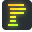

In [5]:
%%pyinstrument
kgs.profiling=True
import pack_ga
kgs.enable_module_profiling(lbfgs_torch_parallel)
import pack_runner
runner = pack_runner.baseline_runner(fast_mode=False)
runner.use_missing_value = True
runner.modifier_dict['n_generations'] = pack_runner.pm(5, lambda r:5, pack_runner.set_ga_prop)
runner.base_ga.ga.do_legalize = False
runner.base_ga.ga.N_trees_to_do = 40
runner.run()


In [6]:
kgs.print_module_profile()


Timer unit: 1e-09 s

Total time: 0 s
File: /mnt/d/packing/code/analysis/../core/lbfgs_torch_parallel.py
Function: _cubic_interpolate at line 13

Line #      Hits         Time  Per Hit   % Time  Line Contents
    13                                           def _cubic_interpolate(x1, f1, g1, x2, f2, g2, bounds=None):
    14                                               # ported from https://github.com/torch/optim/blob/master/polyinterp.lua
    15                                               # Compute bounds of interpolation area
    16                                               if bounds is not None:
    17                                                   xmin_bound, xmax_bound = bounds
    18                                               else:
    19                                                   xmin_bound, xmax_bound = (x1, x2) if x1 <= x2 else (x2, x1)
    20                                           
    21                                               # Code for most commo